<a href="https://colab.research.google.com/github/AkshayaBadugu/cloud-deposit-prediction/blob/main/training_and_evaluation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
from google.colab import files
uploaded = files.upload()  # Upload both data.csv and test_data.csv



Saving data.csv to data.csv
Saving test_data.csv to test_data.csv


In [24]:
import joblib

# Save model
joblib.dump(model, "deposit_rf_model.pkl")

# Save scaler
joblib.dump(scaler, "scaler.pkl")

# Save label encoders for all categorical features
categorical_cols = ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'poutcome']
label_encoders = {}
for col in categorical_cols:
    le = LabelEncoder()
    train_df[col] = le.fit_transform(train_df[col])
    label_encoders[col] = le

joblib.dump(label_encoders, "label_encoders.pkl")


['label_encoders.pkl']

In [25]:
import joblib

joblib.dump(model, "deposit_rf_model.pkl")
joblib.dump(scaler, "scaler.pkl")
joblib.dump(label_encoders, "label_encoders.pkl")

from google.colab import files
files.download("deposit_rf_model.pkl")
files.download("scaler.pkl")
files.download("label_encoders.pkl")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier

from sklearn.metrics import classification_report, confusion_matrix, roc_curve, RocCurveDisplay


In [5]:
train_df = pd.read_csv("data.csv")
test_df = pd.read_csv("test_data.csv")

train_df.head()


,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,deposit
0,38,technician,married,tertiary,no,127,yes,no,cellular,14,oct,113,1,50,2,success,no
1,41,housemaid,married,primary,no,365,no,no,cellular,8,aug,203,5,-1,0,unknown,no
2,39,management,single,tertiary,no,2454,yes,no,cellular,4,may,716,3,263,2,failure,yes
3,49,blue-collar,married,primary,no,6215,yes,no,cellular,11,may,549,1,-1,0,unknown,no
4,37,services,married,secondary,no,1694,yes,yes,cellular,29,jan,404,2,251,6,failure,no


In [7]:
print(train_df.columns)
print(test_df.columns)


Index(['age', 'job', 'marital', 'education', 'default', 'balance', 'housing',
       'loan', 'contact', 'day', 'month', 'duration', 'campaign', 'pdays',
       'previous', 'poutcome', 'deposit'],
      dtype='object')
Index(['age', 'job', 'marital', 'education', 'default', 'balance', 'housing',
       'loan', 'contact', 'day', 'month', 'duration', 'campaign', 'pdays',
       'previous', 'poutcome'],
      dtype='object')


In [9]:
print("Train columns:", train_df.columns.tolist())
print("Test columns:", test_df.columns.tolist())



Train columns: ['age', 'job', 'marital', 'education', 'default', 'balance', 'housing', 'loan', 'contact', 'day', 'month', 'duration', 'campaign', 'pdays', 'previous', 'poutcome', 'deposit']
Test columns: ['age', 'job', 'marital', 'education', 'default', 'balance', 'housing', 'loan', 'contact', 'day', 'month', 'duration', 'campaign', 'pdays', 'previous', 'poutcome']


In [10]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler

# Encode categorical columns
label_enc = LabelEncoder()
for col in train_df.select_dtypes(include='object').columns:
    if col != 'deposit':  # Don't encode the target yet
        train_df[col] = label_enc.fit_transform(train_df[col])

# Encode target label
train_df['deposit'] = label_enc.fit_transform(train_df['deposit'])  # Yes/No → 1/0

# Split features and label
X = train_df.drop('deposit', axis=1)
y = train_df['deposit']

# Split into train and test sets (from train_df itself)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale numeric features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [05:56:01] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


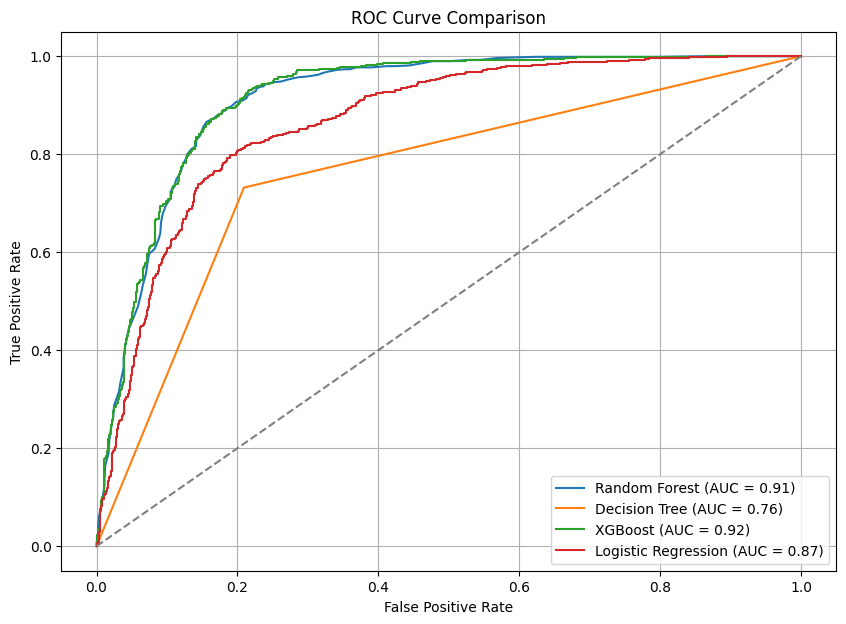

,Model,Accuracy,Precision,Recall,F1-Score,ROC AUC
0,Random Forest,0.852537,0.825359,0.872314,0.848187,0.913629
1,XGBoost,0.848358,0.835206,0.845765,0.840452,0.915394
2,Logistic Regression,0.800000,0.807278,0.757269,0.781474,0.867076
3,Decision Tree,0.762985,0.757853,0.731985,0.744695,0.761354


In [22]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score,
    roc_curve, RocCurveDisplay
)

# Define models
models = {
    'Random Forest': RandomForestClassifier(),
    'Decision Tree': DecisionTreeClassifier(),
    'XGBoost': XGBClassifier(use_label_encoder=False, eval_metric='logloss'),
    'Logistic Regression': LogisticRegression(max_iter=1000)
}

# Store results
results = []
plt.figure(figsize=(10, 7))

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1]

    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_proba)

    # Save scores
    results.append({
        'Model': name,
        'Accuracy': acc,
        'Precision': prec,
        'Recall': rec,
        'F1-Score': f1,
        'ROC AUC': auc
    })

    # Plot ROC Curve
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    plt.plot(fpr, tpr, label=f"{name} (AUC = {auc:.2f})")

# Show ROC Curve
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.title('ROC Curve Comparison')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.grid()
plt.show()

# Display comparison table
results_df = pd.DataFrame(results)
results_df.sort_values(by='F1-Score', ascending=False).reset_index(drop=True)



In [23]:
from sklearn.metrics import classification_report
print("Classification Report:\n")
print(classification_report(y_test, y_pred))


Classification Report:

              precision    recall  f1-score   support

           0       0.79      0.84      0.82       884
           1       0.81      0.76      0.78       791

    accuracy                           0.80      1675
   macro avg       0.80      0.80      0.80      1675
weighted avg       0.80      0.80      0.80      1675

